# C14-hepatocyte analysis

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

/home/fabrost/miniconda3/envs/spols200116/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
%%R
library(ggplot2)

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [4]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

In [32]:
R = c14.models.liver.R

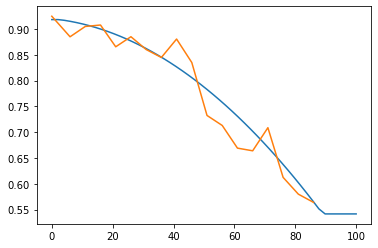

In [34]:
t = np.linspace(0, 100)
ploidy_data = pd.read_excel(c14.models.liver.default_path)
plt.plot(t, R().ploidy(t))
plt.plot(ploidy_data['age_min'], ploidy_data['2C_mean']/100)

In [12]:
parameters = pd.read_hdf('../../../data/julian_fits_200226/richtig_1s_fine2_R.pandas').reset_index()

In [13]:
parameters.head()

,time,para,mean,sd,hpd_15.85%,hpd_84.15%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,std,median_std,percentile.1585,median,percentile.8415
0,0.0,delta2,1.427199,1.883463,0.190036,1.090877,0.030680,0.021695,3768.907249,3768.907249,3274.499889,10271.784484,1.042713,1.883461,2.039767,0.342979,0.644111,2.429375
1,0.0,delta4,0.075903,0.028430,0.052598,0.103858,0.000597,0.000422,2265.505971,2265.505971,2126.614246,1922.321342,1.062228,0.028430,0.028467,0.047347,0.077350,0.099845
2,0.0,kappa24,0.003086,0.002004,0.001000,0.003561,0.000037,0.000026,2977.744034,2977.744034,2886.518228,9876.120061,1.051930,0.002004,0.002100,0.001309,0.002456,0.005083
3,0.0,kappa42,0.021206,0.023751,0.001000,0.024619,0.000572,0.000405,1723.320081,1723.320081,1698.801991,4422.166136,1.077243,0.023751,0.025895,0.002153,0.010887,0.046212
4,0.0,r2,1.426513,1.883452,0.196188,1.093649,0.030688,0.021701,3766.811529,3766.811529,3268.414613,10297.322795,1.042588,1.883450,2.039887,0.342283,0.643086,2.429721


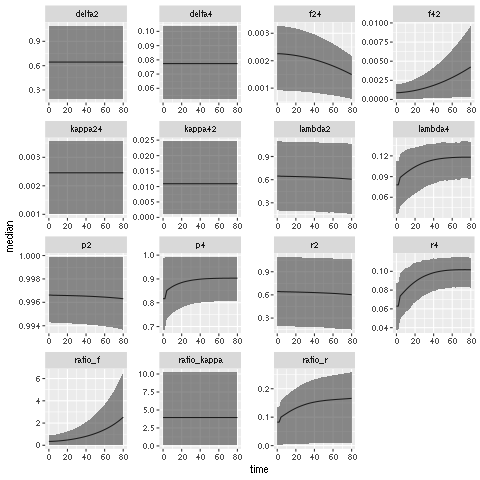

In [14]:
%%R -i parameters 
ggplot(parameters, aes(x=time, y=median, ymin=hpd_15.85., ymax=hpd_84.15.)) + 
    facet_wrap(~para, scale='free') +
    geom_line() +
    geom_ribbon(aes(alpha = 0.1), show.legend=F)

In [57]:
explicit_parameters = parameters[parameters['para'].isin(R().default_parameters.keys())].query('time == 0').set_index('para')['median']
explicit_parameters

para
delta2     0.644111
delta4     0.077350
kappa24    0.002456
kappa42    0.010887
Name: median, dtype: float64

In [59]:
m = R(**R().transform_physical_to_fit(explicit_parameters))

In [78]:
t = np.linspace(0, 80)
implicit_parameters = pd.DataFrame(m.get_implicit_parameters(t))

In [80]:
implicit_parameters['time'] = t

In [89]:
implicit_parameters['f44'] = implicit_parameters['r4'] * (1-m.ploidy(t))

In [93]:
implicit_parameters['f22'] = implicit_parameters['r2'] * (m.ploidy(t))

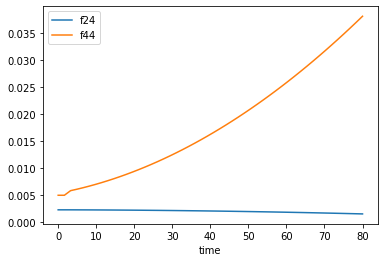

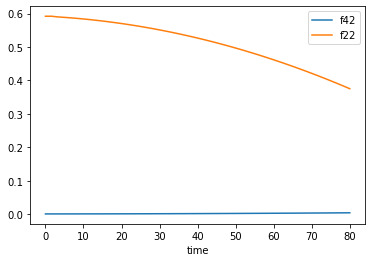

In [96]:
implicit_parameters.plot('time', ['f24', 'f44'])
implicit_parameters.plot('time', ['f42', 'f22'])

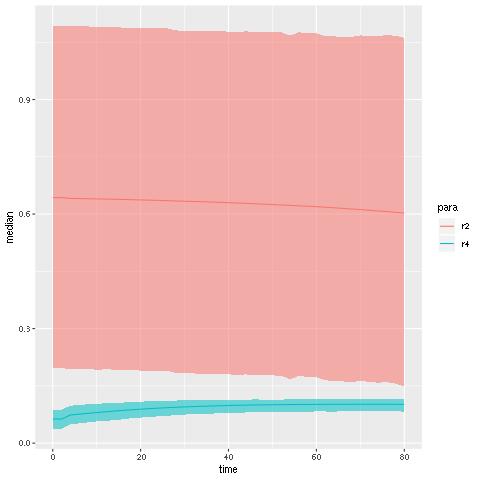

In [97]:
%%R -i parameters
ggplot(parameters[parameters$para %in% c('r2', "r4"),],
       aes(x=time, y=median, ymin=hpd_15.85., ymax=hpd_84.15., fill=para)) + 
    geom_line(aes(color=para)) +
    geom_ribbon(aes(alpha=0), show.legend=F)

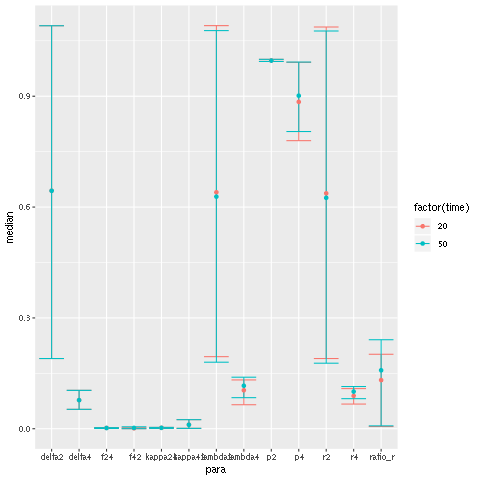

In [98]:
%%R -i parameters
ggplot(parameters[(parameters$time %in% c(20, 50)) & !(parameters$para %in% c('ratio_kappa', 'ratio_f')), ], aes(x=para, y=median, ymin=hpd_15.85., ymax=hpd_84.15., color=factor(time))) + 
    geom_errorbar() + 
    geom_point()